Trial Jupyter Notebook for combining Graph Isomorphism on Quantum Annealer code and ast to networkx graph conversion code


importing necessary stuff

In [2]:
import ast
import networkx as nx  
import sys
from graphviz import Digraph
import showast
import astpretty
import gsgmorph.pyqubo_form as gsgm_pqf
import pprint
import matplotlib.pyplot as plt  


In [3]:
class viz_walker(ast.NodeVisitor):
    def __init__(self):
        self.stack = []
        self.graph = nx.Graph()

    def generic_visit(self, stmt):
        
        node_name = str(stmt)
        parent_name = None

        if self.stack:
            parent_name = self.stack[-1]
        
        self.stack.append(node_name)
        self.graph.add_node(node_name)

        if parent_name:
            self.graph.add_edge(node_name, parent_name)
        
        super(self.__class__, self).generic_visit(stmt)

        self.stack.pop()

In [4]:
# not used anywhere
class mywalker(ast.NodeVisitor):
    def __init__(self):
        self.def_stack = []

    @property
    def in_func_def(self):
        return len(self.def_stack) > 0
    
    def proceed(self, stmt):
        super(self.__class__, self).generic_visit(stmt)
    
    def visit_Call(self, stmt):
        print("***********", stmt.func, stmt.lineno, stmt.args, stmt.kwargs)
        pprint.pprint(dir(stmt))
    
    def visit_FunctionDef(self, stmt):
        func_name = stmt.name

        self.def_stack.append(func_name)

        # Pop this function from stack
        self.def_stack.pop()
    
    def visit_For(self, stmt):
        print("stmt: '{0}', target: '{1}', lineno: '{2}', body: '{3}'".format(\
            str(stmt), stmt.target.id, stmt.lineno, stmt.body))
        self.proceed(stmt)

    def visit_Name(self, stmt):
        if self.in_func_def:
            print("stmt: '{0}', id: '{1}', lineno: '{2}'".format(\
                str(stmt), stmt.id, stmt.lineno))
        
        self.proceed(stmt)
    

'''def main():
    file_url = 'test clone types/test_type_1_clones/test_type_1_a.py'
    with open(file_url, 'r') as fin:
        src = fin.read()

    node = ast.parse(src)
    mw = viz_walker()

    mw.visit(node)

    nx.draw(mw.graph)
    plt.show()

if __name__ == "__main__":
    main()'''

'def main():\n    file_url = \'test clone types/test_type_1_clones/test_type_1_a.py\'\n    with open(file_url, \'r\') as fin:\n        src = fin.read()\n\n    node = ast.parse(src)\n    mw = viz_walker()\n\n    mw.visit(node)\n\n    nx.draw(mw.graph)\n    plt.show()\n\nif __name__ == "__main__":\n    main()'

#### Graph 1

In [5]:
graph_1_file_url = 'test clone types/test_type_3_clones/test_type_3_a.py'
with open(graph_1_file_url, 'r') as fin:
    src = fin.read()
fin.close()

node = ast.parse(src)
graph_1 = viz_walker()
graph_1.visit(node)

# nx.draw(graph_1.graph)
# plt.show()

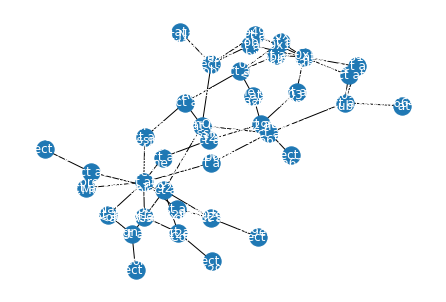

In [6]:
# Get the fixed position
# pos = nx.spring_layout(graph_1, seed = 9999)

# Graph to Embed onto the target graph
nx.draw(graph_1.graph, with_labels = True, font_color = 'w')
plt.show()

#### Target Graph / Graph 2

In [7]:
graph_2_file_url = 'test clone types/test_type_3_clones/test_type_3_b.py'
with open(graph_2_file_url, 'r') as fin:
    src = fin.read()
fin.close()

node = ast.parse(src)
graph_2 = viz_walker()
graph_2.visit(node)

# nx.draw(graph_2.graph)
# plt.show()

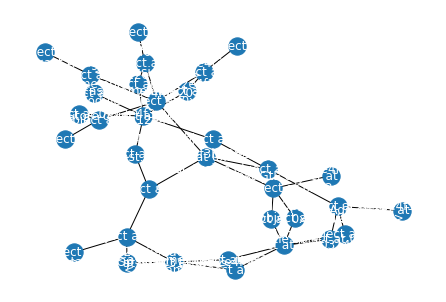

In [8]:
# Get the fixed position
# pos = nx.spring_layout(graph_2, seed = 9999)

# Graph to Embed onto the target graph
nx.draw(graph_2.graph, with_labels = True, font_color = 'w')
plt.show()

In [9]:
graph_1_graph = graph_1.graph
graph_2_graph = graph_2.graph

### Now starts the Quantum Annealing Part

#### Graph Isomorphism

In [10]:
# Get the PyQUBO expression and translation dictionary which allows us to 
# translate from the annealer results to the actual node mapping
pyqubo_exp, sample_translation_dict = gsgm_pqf.graph_isomorphism(graph_1_graph, graph_2_graph)

IncompatibleGraphError: The number of vertices do not match!

#### Sub Graph Isomorphism

In [11]:
if graph_1_graph.number_of_nodes() < graph_2_graph.number_of_nodes():
    pyqubo_exp, sample_translation_dict = gsgm_pqf.subgraph_isomorphism(graph_1_graph, graph_2_graph)
elif graph_1_graph.number_of_nodes() > graph_2_graph.number_of_nodes():
    pyqubo_exp, sample_translation_dict = gsgm_pqf.subgraph_isomorphism(graph_2_graph, graph_1_graph)


In [12]:
# pyqubo_exp, sample_translation_dict = gsgm_pqf.subgraph_isomorphism(graph_to_embed_graph, target_graph_graph)


In [13]:
import neal

# Initiate the annealer
sampler = neal.SimulatedAnnealingSampler()

# Convert the PyQUBO expression to a BQM that can be fed to the annealer
model = pyqubo_exp.compile()
bqm = model.to_bqm()

# Obtain smaples from annealing and choose the one with the lowest energy
# Keep in mind that there exist multiple satisfactory, low-energy solutions!
sampleset = sampler.sample(bqm, num_reads = 100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key = lambda x: x.energy)

In [14]:
# We can use the PyQUBO-translated sample and the sample tranclation dictionary
# from before to geenrate a dictionary that maps nodes from the graph to be embedded
# and the target graph
mapping = gsgm_pqf.translate_sample(best_sample, sample_translation_dict)

In [15]:
mapping

{'<ast.Assign object at 0x12e4f3b50>': '<ast.Assign object at 0x12e329dc0>',
 '<ast.Constant object at 0x12e4f3e20>': '<ast.Name object at 0x10662a610>',
 '<ast.Assign object at 0x12e4f3e80>': '<ast.Assign object at 0x10662aa30>',
 '<ast.Constant object at 0x12e3299a0>': '<ast.Name object at 0x12e329f70>',
 '<ast.Name object at 0x12e329b50>': '<ast.Name object at 0x12e329df0>',
 '<ast.Name object at 0x12e4f3e50>': '<ast.BinOp object at 0x106646d00>',
 '<ast.Name object at 0x12e4f3ee0>': '<ast.Constant object at 0x12e329e20>',
 '<ast.Name object at 0x12e4f3b20>': '<ast.Constant object at 0x12e329610>',
 '<ast.Name object at 0x12e3298b0>': '<ast.Name object at 0x106411fa0>',
 '<ast.Add object at 0x103140b80>': '<ast.Constant object at 0x12e329880>',
 '<ast.Sub object at 0x103140be0>': '<ast.Name object at 0x12e329eb0>',
 '<ast.BinOp object at 0x12e4f3c40>': '<ast.Load object at 0x103140940>',
 '<ast.Name object at 0x12e4f3d90>': '<ast.Name object at 0x12e329850>',
 '<ast.Assign object at

In [16]:
print(type(graph_1_graph))

<class 'networkx.classes.graph.Graph'>


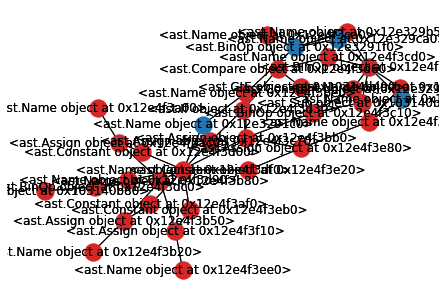

In [17]:
# We can use NetworkX o visualize the subgraph and how it fits onto the target graph

# Invert the mapping so it is from the target graph to the graph_to_embed nodes
inv_mapping = {v: k for k, v in mapping.items()}

# relabel those nodes in the target graph wit hthe node labels from the graph to embed
if graph_1_graph.number_of_nodes() < graph_2_graph.number_of_nodes():
        updated_nodes = nx.relabel_nodes(graph_2_graph, inv_mapping, copy = True)
elif graph_1_graph.number_of_nodes() > graph_2_graph.number_of_nodes():
        updated_nodes = nx.relabel_nodes(graph_1_graph, inv_mapping, copy = True)

# Get the same fixed position used before
pos = nx.spring_layout(updated_nodes, seed = 9999)

# Highlight the nodes that have been relabeled
nx.draw(updated_nodes, 
        pos, 
        with_labels = True, 
        font_color = 'black', 
        nodelist = [key for key in mapping.keys()],
        node_color = "tab:red")
# Difference between the two lists
nx.draw(updated_nodes, 
        pos, 
        with_labels = True, 
        font_color = 'black', 
        nodelist = list(set(updated_nodes.nodes()) - set(mapping.keys())), 
        node_color = "tab:blue")